In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
%pylab inline
import datetime, time
import requests

Populating the interactive namespace from numpy and matplotlib


## Config

In [106]:
symbol = "ETHUSDT"
period = 30
interval = "1h"
delta = 0.08

## Data retrieval 

In [99]:
y_data = []
start_prices = []
amplitude = []
days = list(np.arange(period,-30,-30))
for i, day in enumerate(days):
    if i == len(days)-1:
        continue
    start = datetime.datetime.now() - datetime.timedelta(days=float(day))
    start = int(time.mktime(start.timetuple())*1e3 + start.microsecond/1e3)
    end = datetime.datetime.now() - datetime.timedelta(days=float(days[i+1]))
    end = int(time.mktime(end.timetuple())*1e3 + end.microsecond/1e3)
    print(start,end)
    print(datetime.datetime.fromtimestamp(int(str(start)[:-3])).strftime('%Y-%m-%d'),
          datetime.datetime.fromtimestamp(int(str(end)[:-3])).strftime('%Y-%m-%d')) 
    r = requests.get("https://api.binance.com/api/v1/klines?symbol={}&interval={}&startTime={}&endTime={}".format(
    symbol, interval, start, end))
    r = r.json()
    for array in r:
        y_data.append(np.average([float(array[2]), float(array[3])]))
        start_prices.append(float(array[1]))
        amplitude.append(float(array[2])-float(array[3]))
x_data = np.array(list(range(len(y_data))))

1548462780145 1551054780145
2019-01-26 2019-02-25


## Pseudo-renko

In [100]:
pre = y_data[0] # first datapoint
increment = 0

x_positive = []
y_positive = []
x_negative = []
y_negative = []

# generate delta% change points
for i, point in enumerate(y_data):
    increment += point-pre
    increment_perc = increment/pre
    pre = point
    if increment_perc > delta:
        x_positive.append(i)
        y_positive.append(point)
        increment = 0
    if increment_perc < -delta:
        x_negative.append(i)
        y_negative.append(point)
        increment = 0

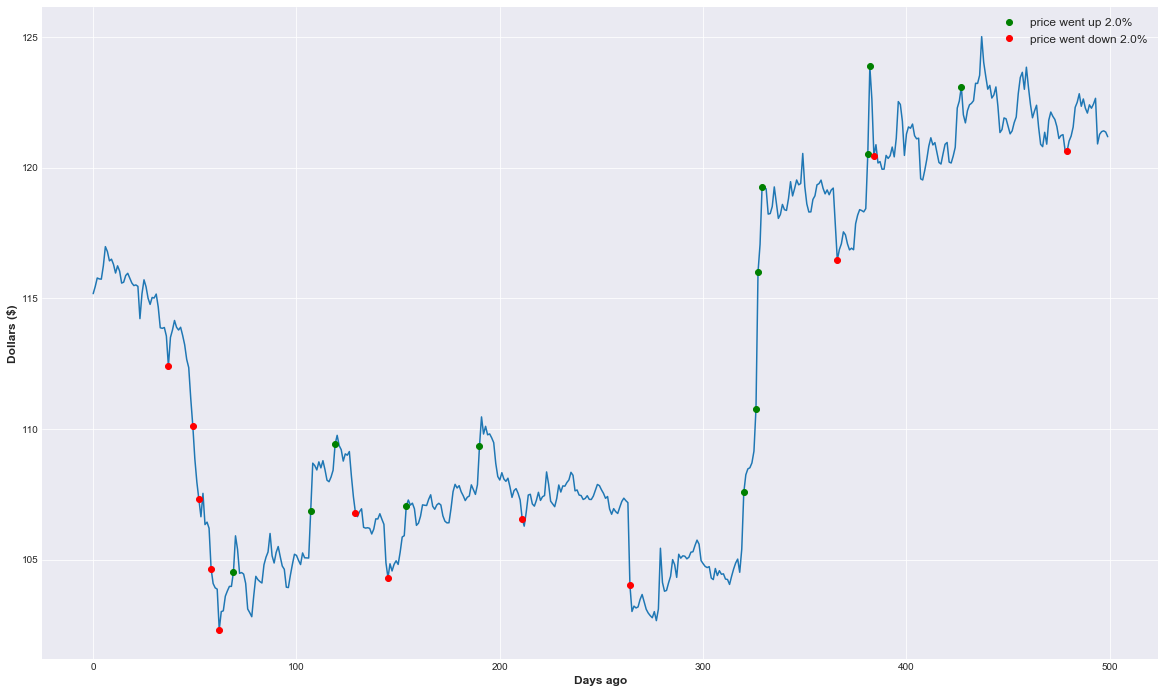

In [101]:
plt.figure(figsize=(20,12))
plt.plot(x_data, y_data, "-")
plt.plot(x_positive, y_positive, "o", color="green", label="price went up {}%".format(delta*100))
plt.plot(x_negative, y_negative, "o", color="red", label="price went down {}%".format(delta*100))
plt.ylabel("Dollars ($)", fontsize=12, fontweight=600)
plt.xlabel("Days ago", fontsize=12, fontweight=600)
plt.legend(fontsize=12);

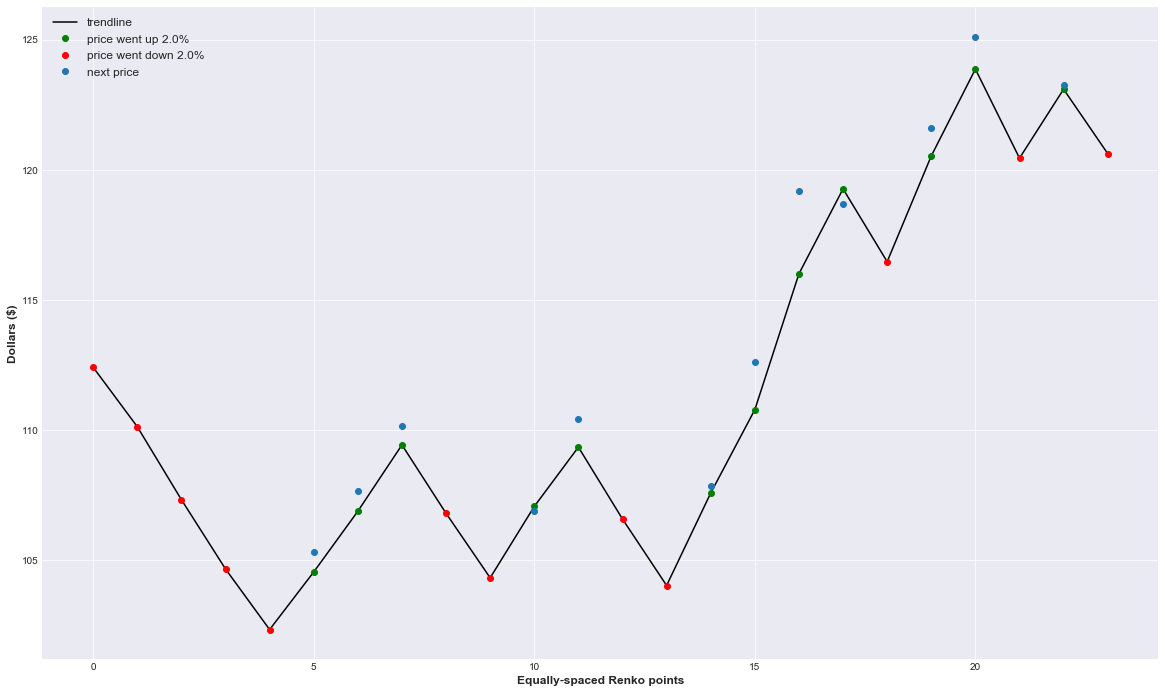

In [102]:
# regular plot
plt.figure(figsize=(20,12))
x_positive_regular = []
x_negative_regular = []
y_data_regular = []
nextprice_positive_regular = []
nextprice_negative_regular = []
amplitude_positive_regular = []
amplitude_negative_regular = []
counter = 0
for i in x_data:
    if i in x_positive:
        x_positive_regular.append(counter)
        y_data_regular.append(y_positive[np.argwhere(np.array(x_positive)==i)[0][0]])
        nextprice_positive_regular.append(start_prices[i+1])
        amplitude_positive_regular.append(amplitude[i])
        counter += 1
    elif i in x_negative:
        x_negative_regular.append(counter)
        y_data_regular.append(y_negative[np.argwhere(np.array(x_negative)==i)[0][0]])
        nextprice_negative_regular.append(start_prices[i+1])
        amplitude_negative_regular.append(amplitude[i])
        counter += 1
x_data_regular = list(range(counter))

plt.plot(x_data_regular, y_data_regular, '-', color="black", label="trendline")
plt.plot(x_positive_regular, y_positive, "o", color="green", label="price went up {}%".format(delta*100))
plt.plot(x_negative_regular, y_negative, "o", color="red", label="price went down {}%".format(delta*100))
plt.ylabel("Dollars ($)", fontsize=12, fontweight=600)
plt.xlabel("Equally-spaced Renko points", fontsize=12, fontweight=600)

plt.plot(x_positive_regular, nextprice_positive_regular, "o", label="next price")

plt.legend(fontsize=12)

## Trading algo

In [103]:
# params
budget = 1000 # dolars
min_steps = 3

### baseline (holding)

In [104]:
init_holding = budget/y_data[0] #btc
end_holding = init_holding*y_data[-1] #euro
print(end_holding)
print(init_holding)

1052.138050792273
8.682439765574127


### renko

In [105]:
usd = 0
btc = budget/y_data[0]
#print(usd,btc)
uptrend = 0
downtrend = 0
cur_price = y_data[0]
buy_x = []
buy_y = []
sell_x = []
sell_y = []
y_data_regular = []
holding_value = []
algo_value = []
buy_sell_steps = 0
usd_progression = []
hold_progression = []
amplitude_progression = []
N_amp = 12
amplitude_threshold = 100000000
for point in x_data_regular:
    
    # assign trend
    if point in x_positive_regular:
        uptrend += 1
        downtrend = 0
        cur_price = y_positive[np.argwhere(np.array(x_positive_regular)==point)[0][0]]
        cur_amplitude = amplitude_positive_regular[np.argwhere(np.array(x_positive_regular)==point)[0][0]]
        next_price = nextprice_positive_regular[np.argwhere(np.array(x_positive_regular)==point)[0][0]]
        y_data_regular.append(cur_price)
        
    elif point in x_negative_regular:
        downtrend += 1
        uptrend = 0
        cur_price = y_negative[np.argwhere(np.array(x_negative_regular)==point)[0][0]]
        cur_amplitude = amplitude_negative_regular[np.argwhere(np.array(x_negative_regular)==point)[0][0]]
        next_price = nextprice_negative_regular[np.argwhere(np.array(x_negative_regular)==point)[0][0]]
        y_data_regular.append(cur_price)
        
        

    # buy
    amplitude_progression.append(cur_amplitude)
    last_amp = np.convolve(amplitude_progression, np.ones((N_amp,))/N_amp, mode='valid')[-1]
    if uptrend == min_steps:
        # uptrend = 0
        # downtrend = 0
        #print("uptrend", cur_price)
        buy_sell_steps +=1
        if usd > 0 and last_amp < amplitude_threshold:
            btc = (usd*0.999)/next_price
            usd = 0
            #print("{}\t{}\t{}".format(round(cur_price,2), round(btc,4), round(usd,2)))
            hold_progression.append((budget/y_data[0])*next_price)
            usd_progression.append(btc*next_price)
            buy_x.append(point)
            buy_y.append(next_price)
        
    # sell
    elif downtrend == min_steps:
        buy_sell_steps +=1
        if btc > 0 and last_amp < amplitude_threshold:
            usd = (btc*0.999)*next_price
            btc = 0
            #print("{}\t{}\t{}".format(round(cur_price,2), round(btc,4), round(usd,2)))
            hold_progression.append((budget/y_data[0])*next_price)
            usd_progression.append(usd)
            sell_x.append(point)
            sell_y.append(next_price)
    else:
        hold_progression.append((budget/y_data[0])*next_price)
        
        if btc > 0:
            usd_progression.append(btc*next_price)
        elif usd > 0:
            usd_progression.append(usd)
    
    # algo value
    if usd > 0:
        algo_value.append(usd)
    elif btc > 0:
        algo_value.append(btc*next_price)
        
    # holding value
    holding_value.append(init_holding*next_price)
        
end_usd = max(usd, btc*next_price)
print("USD final:\t {} $".format(round(end_usd,2)))
print("Gain respect baseline:\t {} %".format(round((end_usd/end_holding)*100)))

USD final:	 1013.88 $
Gain respect baseline:	 96.0 %


In [51]:
# moving average amplitude
amp_raw = [t/20 for t in amplitude_progression] # I reduce amplitude arbitrarily to fit in the plot scale
amp = np.convolve(amp_raw, np.ones((N_amp,))/N_amp, mode='full')

Text(0,0.5,'USDT for every 1000 USDT invested')

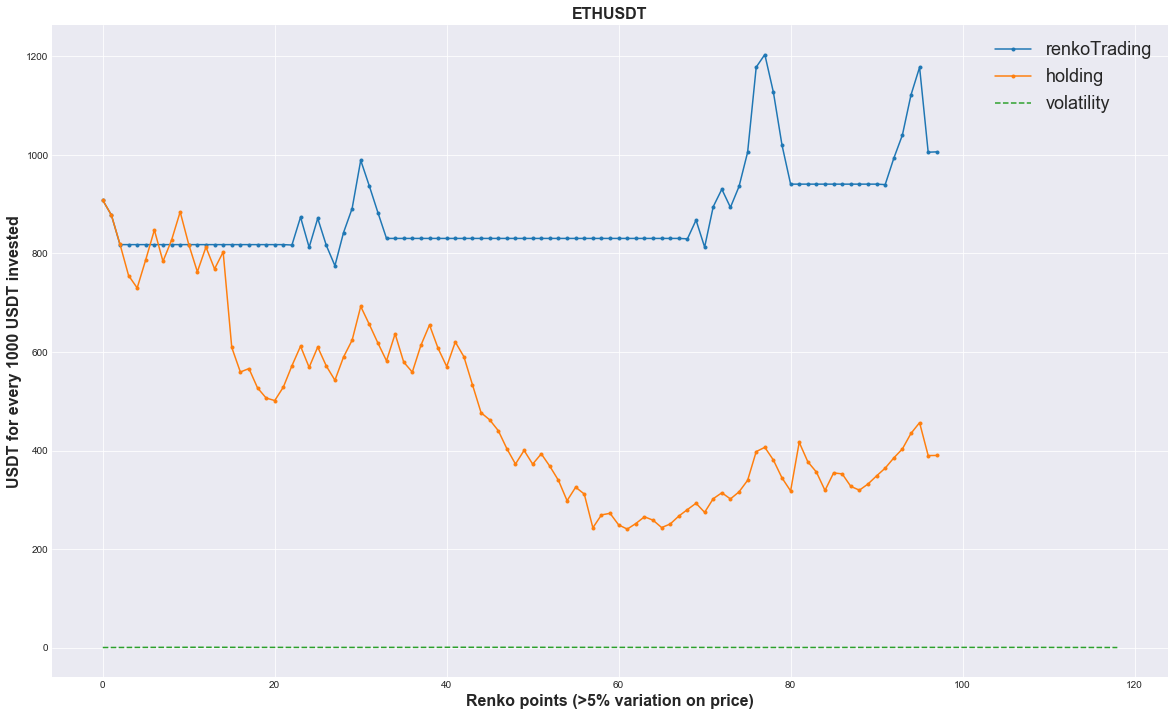

In [52]:
plt.figure(figsize=(20,12))
plt.plot(usd_progression, ".-", label="renkoTrading")
plt.plot(hold_progression, ".-", label="holding")
plt.plot(amp, "--", label="volatility")
plt.legend(fontsize=18)
plt.title(symbol, fontsize=16, fontweight=600)
plt.xlabel("Renko points (>5% variation on price)", fontsize=16, fontweight=600)
plt.ylabel("USDT for every {} USDT invested".format(budget), fontsize=16, fontweight=600)

ValueError: x and y must have same first dimension, but have shapes (132,) and (108,)

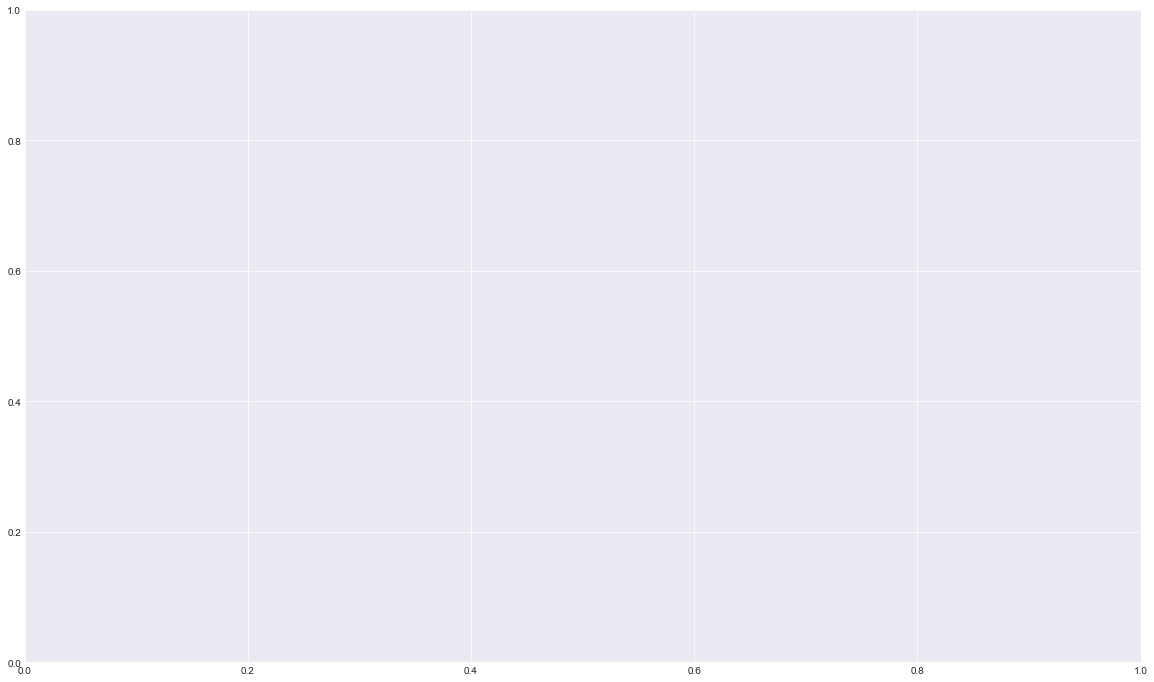

In [53]:
plt.figure(figsize=(20,12))
plt.plot(x_data_regular, y_data_regular, '-', color="grey")
plt.plot(x_positive_regular, y_positive, "o", color="green", markersize=4)
plt.plot(x_negative_regular, y_negative, "o", color="red", markersize=4)
plt.plot(buy_x, buy_y, "o", color="blue", markersize=10, label="buy")
plt.plot(sell_x, sell_y, "o", color="black", markersize=10, label="sell ")
plt.legend(fontsize=12)
plt.xlabel("Renko points", fontsize=12, fontweight=600)
plt.ylabel("Dollars ($)", fontsize=12, fontweight=600)